In [1]:
!pip install tensorflow-addons

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
#from keras.utils.vis_utils import plot_model
from tensorflow import keras
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
work_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset"
train_path = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train"
test_path = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test"

In [5]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


In [6]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

In [7]:

#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=train_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


In [8]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)


(5121, 150, 150, 3) (5121, 4)


In [9]:
# Performing over-sampling of the data, since the classes are imbalanced
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)


(10240, 150, 150, 3) (10240, 4)


In [10]:
#Splitting the data into train, test, and validation sets

#train_data, test_data, train_labels, test_labels = train_test_split(test_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_directory(
    directory= '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
    target_size=(150, 150),
    class_mode='categorical',  # or 'binary' depending on your use case
    batch_size=32,
    shuffle=False  # Ensure no shuffling
)
print(test_dataset.samples)

Found 1279 images belonging to 4 classes.
1279


In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.applications import MobileNetV2, InceptionV3
from keras.models import Model
from keras.layers import Concatenate, Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [13]:
base_model1 = MobileNetV2(input_shape=(150,150,3),weights='imagenet', include_top=False)

for layer in base_model1.layers:
    
    layer.trainable=False


MobileNetV2_model = Sequential([
        base_model1,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, kernel_initializer='he_uniform', activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, kernel_initializer='he_uniform', activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, kernel_initializer='he_uniform', activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, kernel_initializer='he_uniform', activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "MobileNetV2_model")



9406464/9406464 [==============================] - 0s 0us/step


In [14]:
base_model2=InceptionV3(input_shape=(150,150,3),weights='imagenet',include_top=False)

for layer in base_model2.layers:
    layer.trainable=False

InceptionV3_model = Sequential([
        base_model2,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, kernel_initializer='he_uniform', activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, kernel_initializer='he_uniform', activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, kernel_initializer='he_uniform', activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, kernel_initializer='he_uniform', activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "InceptionV3_model")





87910968/87910968 [==============================] - 0s 0us/step


In [15]:
base_model3=ResNet50(input_shape=(150,150,3),weights='imagenet',include_top=False)

for layer in base_model3.layers:
    layer.trainable=False

ResNet50_model = Sequential([
        base_model3,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, kernel_initializer='he_uniform', activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, kernel_initializer='he_uniform', activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, kernel_initializer='he_uniform', activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, kernel_initializer='he_uniform', activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "ResNet50_model")





94765736/94765736 [==============================] - 1s 0us/step


In [16]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]


In [17]:
# Creating Check_Point
#Check_Point to save best model per epoch
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = '/kaggle/working/best_model.h5'

checkpoint=ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [18]:
MobileNetV2_model.compile(optimizer='adam',  loss=tf.losses.CategoricalCrossentropy(), metrics=METRICS)

InceptionV3_model.compile(loss=tf.losses.CategoricalCrossentropy(), optimizer="adam", metrics=METRICS)
ResNet50_model.compile(loss=tf.losses.CategoricalCrossentropy(), optimizer="adam", metrics=METRICS)

In [19]:
EPOCHS=50
history1 = MobileNetV2_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), 
                                 epochs=EPOCHS,
                                callbacks=[checkpoint])

Epoch 1/50


2024-01-12 12:56:45.551034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inMobileNetV2_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


255/256 [============================>.] - ETA: 0s - loss: 1.4411 - accuracy: 0.7342 - precision: 0.4436 - recall: 0.2483 - auc: 0.6550
Epoch 1: val_accuracy improved from -inf to 0.83191, saving model to /kaggle/working/best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - 21s 42ms/step - loss: 1.4400 - accuracy: 0.7342 - precision: 0.4436 - recall: 0.2483 - auc: 0.6553 - val_loss: 0.8307 - val_accuracy: 0.8319 - val_precision: 0.8192 - val_recall: 0.4204 - val_auc: 0.8834
Epoch 2/50
255/256 [============================>.] - ETA: 0s - loss: 0.9268 - accuracy: 0.8087 - precision: 0.6952 - recall: 0.4181 - auc: 0.8423
Epoch 2: val_accuracy improved from 0.83191 to 0.85352, saving model to /kaggle/working/best_model.h5
256/256 [==============================] - 8s 29ms/step - loss: 0.9258 - accuracy: 0.8089 - precision: 0.6958 - recall: 0.4183 - auc: 0.8426 - val_loss: 0.6753 - val_accuracy: 0.8535 - val_precision: 0.8081 - val_recall: 0.5430 - val_auc: 0.9160
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.8262 - precision: 0.7445 - recall: 0.4642 - auc: 0.8777
Epoch 3: val_accuracy improved from 0.85352 to 0.86060, saving model to /kaggle/working/best_model.h5
256/256 [

In [20]:
EPOCHS=50
history2 = InceptionV3_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), 
                                 epochs=EPOCHS,
                                callbacks=[checkpoint])

Epoch 1/50


2024-01-12 13:05:16.456572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inInceptionV3_model/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 [==============================] - ETA: 0s - loss: 1.3898 - accuracy: 0.7849 - precision: 0.6057 - recall: 0.3995 - auc: 0.7768
Epoch 1: val_accuracy did not improve from 0.96326
256/256 [==============================] - 23s 54ms/step - loss: 1.3898 - accuracy: 0.7849 - precision: 0.6057 - recall: 0.3995 - auc: 0.7768 - val_loss: 0.8164 - val_accuracy: 0.8297 - val_precision: 0.7577 - val_recall: 0.4688 - val_auc: 0.8751
Epoch 2/50
255/256 [============================>.] - ETA: 0s - loss: 0.9444 - accuracy: 0.8051 - precision: 0.6875 - recall: 0.4037 - auc: 0.8353
Epoch 2: val_accuracy did not improve from 0.96326
256/256 [==============================] - 10s 41ms/step - loss: 0.9438 - accuracy: 0.8051 - precision: 0.6874 - recall: 0.4039 - auc: 0.8355 - val_loss: 0.6946 - val_accuracy: 0.8478 - val_precision: 0.7964 - val_recall: 0.5254 - val_auc: 0.9071
Epoch 3/50
255/256 [============================>.] - ETA: 0s - loss: 0.8236 - accuracy: 0.8249 - precision: 0.7447 - rec

In [21]:
# EPOCHS=50
# history3 = ResNet50_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), 
#                                  epochs=EPOCHS,
#                                 callbacks=[checkpoint])

Epoch 1/50


2024-01-12 13:14:58.770752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inResNet50_model/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 [==============================] - ETA: 0s - loss: 1.6805 - accuracy: 0.7506 - precision: 0.5021 - recall: 0.2810 - auc: 0.6758
Epoch 1: val_accuracy did not improve from 0.96326
256/256 [==============================] - 27s 78ms/step - loss: 1.6805 - accuracy: 0.7506 - precision: 0.5021 - recall: 0.2810 - auc: 0.6758 - val_loss: 1.3642 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5946
Epoch 2/50
256/256 [==============================] - ETA: 0s - loss: 1.4260 - accuracy: 0.7372 - precision: 0.3895 - recall: 0.0906 - auc: 0.5845
Epoch 2: val_accuracy did not improve from 0.96326
256/256 [==============================] - 18s 70ms/step - loss: 1.4260 - accuracy: 0.7372 - precision: 0.3895 - recall: 0.0906 - auc: 0.5845 - val_loss: 1.2415 - val_accuracy: 0.7598 - val_precision: 0.8509 - val_recall: 0.0474 - val_auc: 0.7224
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 1.2839 - accuracy: 0.7556 - precision: 0.55

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



256/256 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.8156 - precision: 0.7445 - recall: 0.3992 - auc: 0.8449
Epoch 39: val_accuracy did not improve from 0.96326
256/256 [==============================] - 17s 67ms/step - loss: 0.9234 - accuracy: 0.8156 - precision: 0.7445 - recall: 0.3992 - auc: 0.8449 - val_loss: 0.7259 - val_accuracy: 0.8424 - val_precision: 0.8189 - val_recall: 0.4746 - val_auc: 0.9039
Epoch 40/50
256/256 [==============================] - ETA: 0s - loss: 0.9176 - accuracy: 0.8151 - precision: 0.7465 - recall: 0.3943 - auc: 0.8472
Epoch 40: val_accuracy did not improve from 0.96326
256/256 [==============================] - 17s 67ms/step - loss: 0.9176 - accuracy: 0.8151 - precision: 0.7465 - recall: 0.3943 - auc: 0.8472 - val_loss: 0.7391 - val_accuracy: 0.8463 - val_precision: 0.8616 - val_recall: 0.4590 - val_auc: 0.9064
Epoch 41/50
256/256 [==============================] - ETA: 0s - loss: 0.9191 - accuracy: 0.8160 - precision: 0.7486 -

In [22]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

model_1 = load_model('/kaggle/working/best_model.h5')
model_1 = Model(inputs=model_1.inputs, outputs=model_1.outputs, name='name_of_model_1')

model_2 = load_model('/kaggle/working/best_model.h5')
model_2 = Model(inputs=model_2.inputs, outputs=model_2.outputs, name='name_of_model_2')

# model_3 = load_model('/kaggle/working/best_model.h5')
# model_3 = Model(inputs=model_3.inputs, outputs=model_3.outputs, name='name_of_model_3')

models = [model_1, model_2]
model_input = Input(shape=(150, 150, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')


In [23]:
ensemble_model.compile(loss=tf.losses.CategoricalCrossentropy(), optimizer="adam", metrics=METRICS)

In [24]:
EPOCHS=50
history = ensemble_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), 
                                 epochs=EPOCHS)

Epoch 1/50


2024-01-12 13:30:30.481784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/name_of_model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 [==============================] - 43s 95ms/step - loss: 0.1475 - accuracy: 0.9534 - precision: 0.9563 - recall: 0.8524 - auc: 0.9909 - val_loss: 0.2281 - val_accuracy: 0.9623 - val_precision: 0.9290 - val_recall: 0.9194 - val_auc: 0.9894
Epoch 2/50
256/256 [==============================] - 20s 78ms/step - loss: 0.1444 - accuracy: 0.9791 - precision: 0.9649 - recall: 0.9509 - auc: 0.9971 - val_loss: 0.2370 - val_accuracy: 0.9611 - val_precision: 0.9248 - val_recall: 0.9189 - val_auc: 0.9888
Epoch 3/50
256/256 [==============================] - 20s 77ms/step - loss: 0.1521 - accuracy: 0.9774 - precision: 0.9618 - recall: 0.9470 - auc: 0.9971 - val_loss: 0.2415 - val_accuracy: 0.9606 - val_precision: 0.9234 - val_recall: 0.9185 - val_auc: 0.9885
Epoch 4/50
256/256 [==============================] - 20s 77ms/step - loss: 0.1535 - accuracy: 0.9788 - precision: 0.9643 - recall: 0.9502 - auc: 0.9965 - val_loss: 0.2651 - val_accuracy: 0.9609 - val_precision: 0.9235 - val_recall: 0.91

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



256/256 [==============================] - 20s 77ms/step - loss: 0.1409 - accuracy: 0.9801 - precision: 0.9667 - recall: 0.9534 - auc: 0.9973 - val_loss: 0.2573 - val_accuracy: 0.9608 - val_precision: 0.9239 - val_recall: 0.9189 - val_auc: 0.9866
Epoch 28/50
256/256 [==============================] - 20s 77ms/step - loss: 0.1463 - accuracy: 0.9785 - precision: 0.9639 - recall: 0.9495 - auc: 0.9972 - val_loss: 0.2508 - val_accuracy: 0.9614 - val_precision: 0.9258 - val_recall: 0.9194 - val_auc: 0.9858
Epoch 29/50
256/256 [==============================] - 20s 77ms/step - loss: 0.1405 - accuracy: 0.9804 - precision: 0.9671 - recall: 0.9542 - auc: 0.9974 - val_loss: 0.2457 - val_accuracy: 0.9623 - val_precision: 0.9269 - val_recall: 0.9219 - val_auc: 0.9882
Epoch 30/50
256/256 [==============================] - 20s 77ms/step - loss: 0.1418 - accuracy: 0.9811 - precision: 0.9686 - recall: 0.9554 - auc: 0.9972 - val_loss: 0.2471 - val_accuracy: 0.9613 - val_precision: 0.9249 - val_recall: 0

In [25]:
ensemble_model.evaluate(test_dataset)

40/40 [==============================] - 8s 105ms/step - loss: 1.8983 - accuracy: 0.8147 - precision: 0.6340 - recall: 0.6122 - auc: 0.8299


[1.8983310461044312,
 0.8146989941596985,
 0.6340081095695496,
 0.6121970415115356,
 0.8298542499542236]

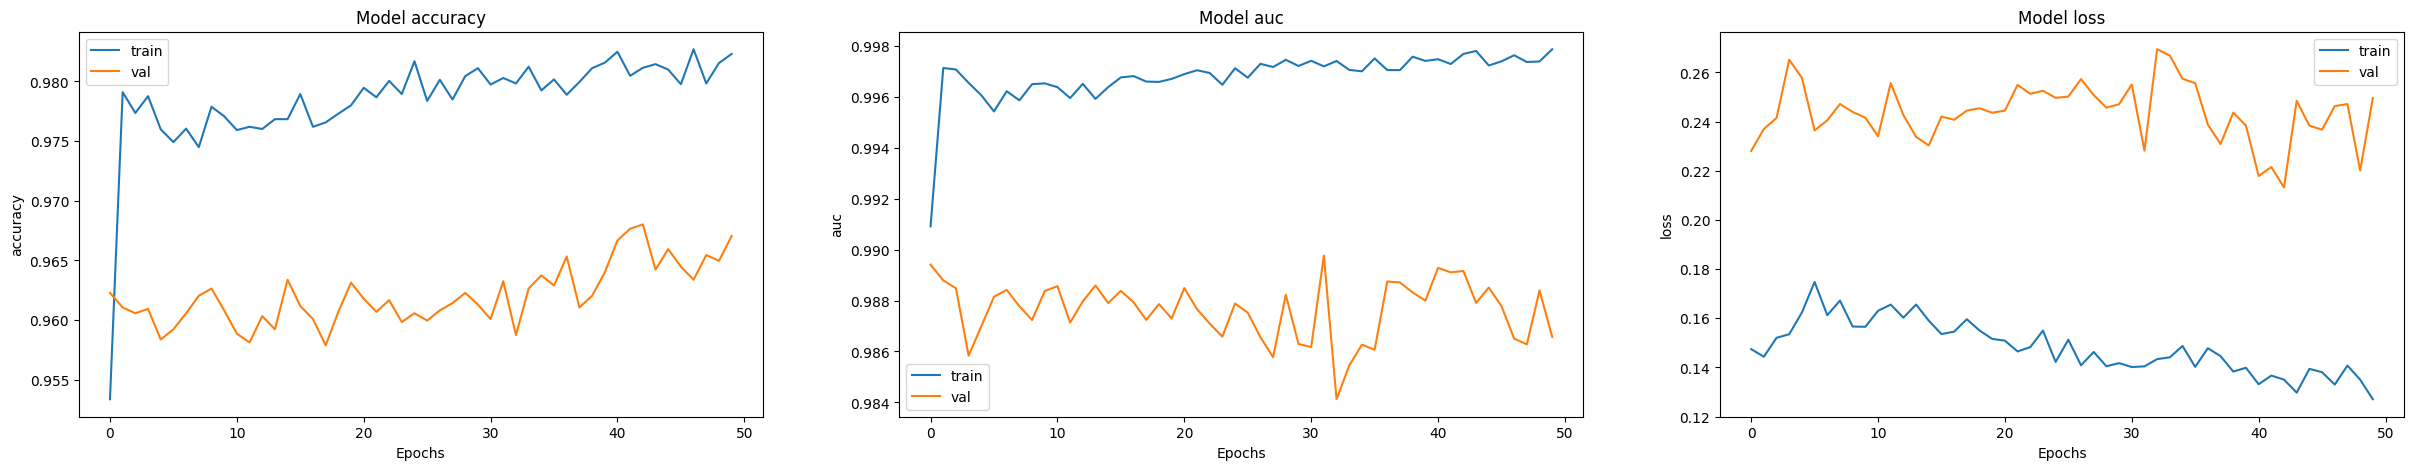

In [26]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [27]:
# Number of batches in the test dataset
num_batches = len(test_dataset)

# Initialize an empty list to store the test labels
all_test_labels = []

# Iterate through the test dataset to extract labels
for _ in range(num_batches):
    _, batch_labels = test_dataset.next()
    all_test_labels.append(batch_labels)

# Concatenate the labels from all batches to get the complete test labels
test_labels = np.concatenate(all_test_labels)
print(test_labels)
#Predicting the test data

pred_labels =ensemble_model.predict(test_dataset)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
40/40 [==============================] - 6s 72ms/step


In [28]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.44      0.51      0.48       179
VeryMildDemented       0.15      0.50      0.23        12
    MildDemented       0.74      0.70      0.72       640
ModerateDemented       0.58      0.56      0.57       448

       micro avg       0.62      0.62      0.62      1279
       macro avg       0.48      0.57      0.50      1279
    weighted avg       0.64      0.62      0.63      1279
     samples avg       0.62      0.62      0.62      1279



In [31]:
test_labels = test_dataset.classes

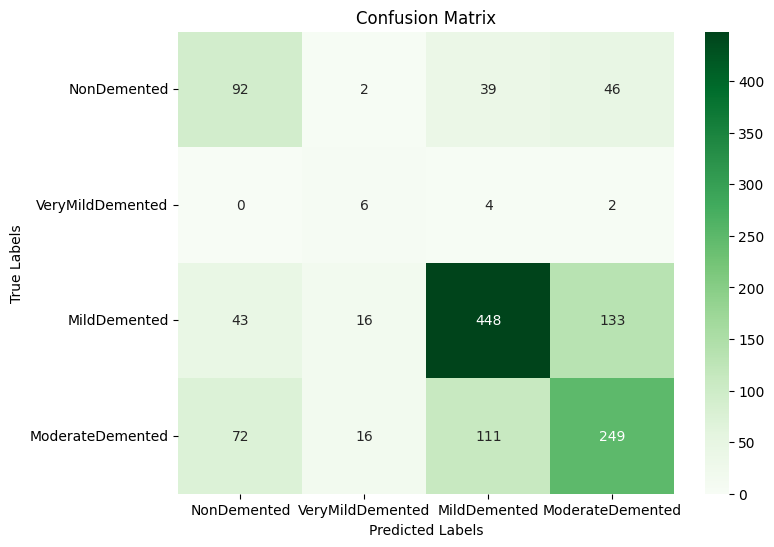

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming test_labels are integer labels
one_hot_test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=4)

# Get the predicted class labels from the one-hot encoded format
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(one_hot_test_labels, axis=1)

# Compute the confusion matrix
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()